# Figsetup
Using chou 20210513 unsort data.<br>
shortcaption: Temporal kernel of a mP-RGC <br>
label: TK

In [1]:
filename = 'TK'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
from scipy.optimize import curve_fit
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

plt.rcParams['figure.facecolor'] = 'white'
# plt.rcParams["font.family"] = "Times New Roman"
# plt.rcParams["font.size"] = 16
plt.rcParams["mathtext.fontset"] = "cm"

In [3]:
import import_ipynb
try:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\python-code\\Modules')
except:
    os.chdir('C:\\Users\\llinc\\GitHub\\python-code\\Modules')
from StimulusnResponse import expSnR

importing Jupyter notebook from StimulusnResponse.ipynb


In [4]:
def ensure_dir(file_path):
    if not os.path.exists(file_path):
        os.makedirs(file_path)

In [5]:
def NGD2L_TK_AS(T, epsilon, gamma, omegastar, deltastar, tau_y, Dmp):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    
    Kw = -Dmp*( 1/np.cos(deltastar)*np.exp(-epsilon*T)*np.cos(T*omegastar+deltastar) -np.exp(-gamma*T) )
    w = np.convolve(x, Kw, 'full')[:len(T):50]*dt
    return w/(dt)

In [6]:
#This function deals with differentiation of angle within [-pi,pi).
#It will fail if angle array x change too fast.
def angular_gradient(x):
    diffx= np.gradient(x)
    diffx[np.abs(diffx)>0.6*np.pi] -= np.pi*diffx[np.abs(diffx)>0.6*np.pi]/abs(diffx[np.abs(diffx)>0.6*np.pi])
    return diffx

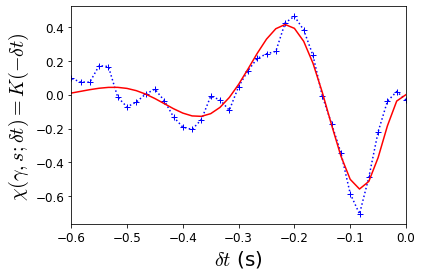

In [7]:
plt.rcParams["font.size"] = 12

annots = loadmat('D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\merge\\merge_0224_cSTA_wf_3min_Q100_re', squeeze_me = True)
x = annots['bin_pos']
x = (x-np.mean(x))/np.std(x)
dt = 1/60

# cSTA_list = [0]*60
# dcn = []
# fig, ax = plt.subplots(nrows=8, ncols=8, constrained_layout=True, sharex=True, sharey=True)

cn = 9

spike = annots['reconstruct_spikes'][cn-1]
rstate, _ = np.histogram(spike, np.arange(len(x)+1)*dt)

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
OLEDtaxis = taxis

plt.plot(taxis, cSTA, 'b+:')
OLEDcSTA = cSTA


name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
para_dict['error'] = np.zeros(60)

epsilon = 10. #1/sec
gamma = 25.
omegastar = 30. 
deltastar = 0.
tau_y = 0.04
Dmp = 10.

popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA, 
                      p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                      bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))

for l in range(len(popt)):
    para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
OLEDfit_cSTA = fit_cSTA
# para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
plt.plot(taxis, fit_cSTA, 'r-')
plt.xlabel(r'$\delta t$ (s)', fontsize = 20)
plt.ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 20)

plt.xlim([-0.6,0])
fig = plt.gcf()
ax = plt.gca()



In [8]:
BS = loadmat('D:\\GoogleDrive\\retina\\oled_boundary_set', squeeze_me =True)

exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20210513\\'
direction = 'UD'

SVDnSTK = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\STK.mat'
                  , squeeze_me =True)
RFprop  = loadmat(exp_folder+'Analyzed_data\\30Hz_27_RF_15min_re\\unsort\\RF_properties.mat'
                  , squeeze_me =True)

loadfiles = np.load(exp_folder+'\\Analyzed_data\\fitNGD2LASpara.npz', allow_pickle=True)

In [9]:
r = RFprop['RF_properties']['radius']

RFprop = RFprop['RF_properties']

STK = SVDnSTK['gauss_RF']

In [10]:
centerx = (RFprop['X_Coor'][cn-1]-BS['leftx_bd'])/(BS['rightx_bd']-BS['leftx_bd'])*27-0.5
centery = (RFprop['Y_Coor'][cn-1]-BS['lefty_bd'])/(BS['righty_bd']-BS['lefty_bd'])*27-0.5
centerx, centery

(3.947904144315487, 16.116156171916682)

In [11]:
rSTK = STK[:,:,:,cn-1].reshape((30,-1))
U,sigma,VT=np.linalg.svd(rSTK)

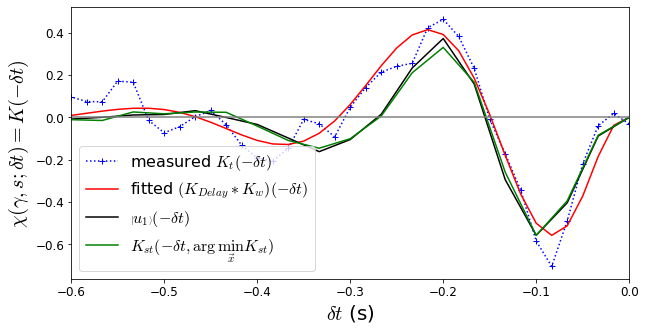

In [12]:
ax.plot(np.arange(31)*-(1/30), np.append(0,U[:,0])/np.min(U[:,0])*np.min(fit_cSTA), 'k')
T_STKmin = STK[:, int(centery), int(centerx), cn-1]
ax.plot(np.arange(31)*-(1/30), np.append(0,T_STKmin)/np.min(T_STKmin)*np.min(fit_cSTA), 'g')
ax.axhline(0, c='gray')
ax.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$', r'$\left| u_1 \right\rangle(-\delta t)$',
            r'$K_{st}(-\delta t, \arg\min_\vec{x} K_{st})$'), fontsize = 16 )
fig.set_size_inches(10, 5)
fig
# plt.xlabel(r'$\delta t$')
# plt.ylabel(r'$\left| u_1 \right\rangle(\delta t)$')
# plt.title(r'$\left| u_1 \right\rangle$', fontsize=20)
# plt.xlim([-1,0])
# plt.gcf().set_size_inches(3,1.5)
# plt.gcf().savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\R\\u1.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)

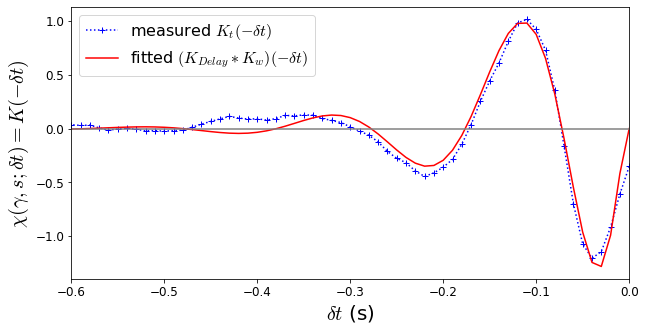

In [13]:
plt.rcParams["font.size"] = 12

dt = 0.01
x_list, T_list, rstate_list = expSnR(['D:\\GoogleDrive\\retina\\Chou\'s data\\20200408\\20200408_cSTA_sort_unit1'], dt, 'LED', np.arange(60)+1)
x = x_list[0]
x = x-np.mean(x)/np.std(x)
# cSTA_list = [0]*60
# dcn = []
# fig, ax = plt.subplots(nrows=8, ncols=8, constrained_layout=True, sharex=True, sharey=True)

cn = 53

rstate = rstate_list[0][cn,:]

cSTA = np.correlate(x, rstate, 'same')/ np.correlate(np.ones_like(x), rstate, 'same')
cSTA = cSTA[int(len(cSTA)/2):int(len(cSTA)/2-1/dt)-1:-1]
taxis = -np.arange(len(cSTA))*dt
LEDtaxis = taxis

plt.plot(taxis, cSTA, 'b+:')
LEDcSTA = cSTA



name_list = ['epsilon', 'gamma', 'omegastar', 'deltastar', 'tau_y', 'Dmp']
para_dict = {}
for l in range(len(name_list)):
    para_dict[name_list[l]] = np.zeros(60)
#-------------------------------------
para_dict['error'] = np.zeros(60)

epsilon = 10. #1/sec
gamma = 25.
omegastar = 30. 
deltastar = 0.
tau_y = 0.04
Dmp = 10.

popt,pcov = curve_fit(NGD2L_TK_AS, np.abs(taxis), cSTA, 
                      p0     =  [epsilon, gamma , omegastar, deltastar, tau_y, Dmp   ],
                      bounds = ([0      , 0     , 0        , -np.pi/2 , 0    , 0     ], 
                                [np.inf , np.inf, np.inf   ,  np.pi/2 , 0.1  , np.inf ] ))

for l in range(len(popt)):
    para_dict[name_list[l]][cn] = popt[l]
#     print(popt)
fit_cSTA = NGD2L_TK_AS(np.abs(taxis), *popt).copy()
LEDfit_cSTA = fit_cSTA
# para_dict['error'][cn] = sum((fit_cSTA_list[cn]-cSTA_list[cn])**2)
plt.plot(taxis, fit_cSTA, 'r-')
plt.xlabel(r'$\delta t$ (s)', fontsize = 20)
plt.ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 20)

plt.axhline(0, c='gray')
plt.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$'), fontsize = 16 )
plt.xlim([-0.6,0])
fig = plt.gcf()
fig.set_size_inches(10, 5)

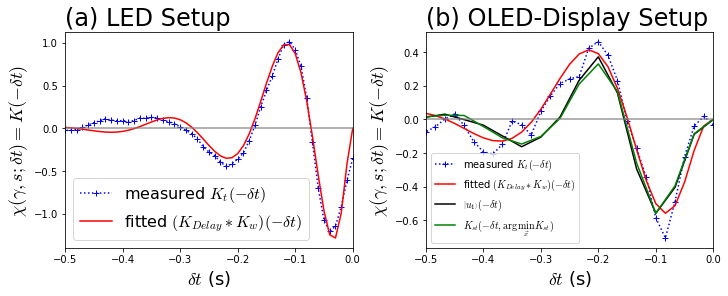

In [16]:
plt.rcParams["font.size"] = 10

fig, (ax2, ax3) = plt.subplots(nrows=1, ncols=2, constrained_layout=True)
ax2.plot(LEDtaxis, LEDcSTA, 'b+:')
ax2.plot(LEDtaxis, LEDfit_cSTA, 'r-')
ax2.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$'), fontsize = 16 )
ax2.set_title('(a) LED Setup', fontsize = 24, loc='left')

ax3.plot(OLEDtaxis, OLEDcSTA, 'b+:')
ax3.plot(OLEDtaxis, OLEDfit_cSTA, 'r-')
ax3.plot(np.arange(31)*-(1/30), np.append(0,U[:,0])/np.min(U[:,0])*np.min(OLEDfit_cSTA), 'k')
ax3.plot(np.arange(31)*-(1/30), np.append(0,T_STKmin)/np.min(T_STKmin)*np.min(OLEDfit_cSTA), 'g')
ax3.legend( (r'measured $K_t(-\delta t)$', r'fitted $(K_{Delay}*K_w)(-\delta t)$', r'$\left| u_1 \right\rangle(-\delta t)$',
            r'$K_{st}(-\delta t, \arg\min_\vec{x} K_{st})$'), fontsize = 10 )
ax3.set_title('(b) OLED-Display Setup', fontsize = 24, loc='left')

for ax in (ax2, ax3):
    ax.axhline(0, c='gray', alpha = 0.8)
    ax.set_xlim([-0.5,0])
    ax.set_xlabel(r'$\delta t$ (s)', fontsize = 18)
    ax.set_ylabel('$\chi(\gamma, s; \delta t) = K(-\delta t)$ ', fontsize = 18)
fig.set_size_inches(10, 4)

In [17]:
# plt.plot(STK[:, 16, 4,cn-1])
fig.savefig('D:\\GoogleDrive\\retina\\thesis\\fig\\R\\'+filename+'.png',  bbox_inches='tight', pad_inches=0.1, dpi=300)